In [97]:
import glob
import time

import ajf_utils
import BeamWithSprings as bm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ajf_bridge_fem import *
from scipy import optimize, stats

import ajf_noise_model
import ajf_plts

plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

# Run dynamic and static simulations to estimate noise

In [178]:
MODEL = "GH"
RUN_ID = "2023-02-05T19:45:04.032244_GH_0.05-step-delta"

N_filter = 10
N_error = 1000
F_SIM = 128

In [179]:
if MODEL == "LB":
    beam = construct_model_LB()
    DOFS = [beam.x_pos_to_rot_dof(x) for x in [0, LB_span_length]]
    LOC_NAMES = ["L", "R"]
elif MODEL == "GH":
    beam = construct_model_GH()
    DOFS = [
        beam.x_pos_to_rot_dof(x)
        for x in [
            GH_side_span_length,
            GH_side_span_length + GH_center_span_length,
        ]
    ]
    LOC_NAMES = ["L_pier", "R_pier"]
else:
    raise Exception("Unknown model")

noise_model = ajf_noise_model.NoiseModel(req_Fs=F_SIM)

WEIGHT_COLS = [f"W{i+1}" for i in range(6)]
SPACING_COLS = [f"S{i}" for i in range(6)]


def process_row(
    row,
    beam,
    noise_model,
    fs,
    fc,
):

    beam.E = row.E_val
    beam.damp_ratio = 0.0
    beam.update_model()

    res = dict()

    # STATIC SIM
    _, stat_disp = beam.perform_static_sim(
        row[WEIGHT_COLS].values,
        row[SPACING_COLS].values,
        force_step=(1.0 / fs) * row.speed,
    )
    # DYNAMIC SIM
    _, dyn_disp, _, _ = beam.perform_dynamic_sim(
        row[WEIGHT_COLS].values,
        row[SPACING_COLS].values,
        row.speed,
        time_step=(1.0 / fs),
    )

    for d, l in zip(DOFS, LOC_NAMES):
        res[l + "_stat"] = np.ptp(stat_disp[d])
        # res[l + "_dyn"] = np.ptp(dyn_disp[d])
        res[l + "_filt"] = np.ptp(
            noise_model.unpad(
                ajf_noise_model.lp_filter(
                    noise_model.pad_and_add_noise(dyn_disp[d], PAD_LEN=10 * fs),
                    Fs=fs,
                    Fc=fc,
                ),
                PAD_LEN=10 * fs,
            )
        )

    return res

# Estimate "optimal" low-pass cut-off frequency

In [194]:
# Reset seed used to generate random values
SEED = ajf_plts.get_seed("6b_estimate_and_add_noise.ipynb")

df = pd.read_parquet("./vehicle_loads.parquet").sample(n=N_filter, random_state=SEED)
df.speed = 40.0
df.head()

,seq_month,year,month,day,hour,minute,dayofweek,air_temperature,freq,E_val,...,W4,W5,W6,S0,S1,S2,S3,S4,S5,speed
5998721,717,59,9,27,16,44,1,8.480000,5.676452,2.775636e+10,...,77472.535,0.0,0.0,0.0,1.90,5.00,6.35,NaN,NaN,40.0
4720917,565,47,1,4,19,37,0,4.723333,5.781529,2.878500e+10,...,0.000,0.0,0.0,0.0,6.15,7.40,NaN,NaN,NaN,40.0
3503544,419,34,11,12,15,33,1,7.950000,5.738492,2.836370e+10,...,96105.170,0.0,0.0,0.0,1.75,5.05,6.40,NaN,NaN,40.0
372186,44,3,8,17,15,27,3,12.525000,5.616622,2.717067e+10,...,0.000,0.0,0.0,0.0,6.70,NaN,NaN,NaN,NaN,40.0
5932460,709,59,1,29,12,20,5,4.533333,5.772652,2.869810e+10,...,56878.570,58839.9,0.0,0.0,3.75,9.60,10.90,12.2,NaN,40.0


In [195]:
def loss(fc):
    results = pd.DataFrame(
        df.apply(
            process_row, axis=1, beam=beam, noise_model=noise_model, fs=F_SIM, fc=fc
        ).to_list()
    )
    feat_error = np.array(
        [results[l + "_filt"] - results[l + "_stat"] for l in LOC_NAMES]
    )
    return np.sqrt(np.mean(feat_error**2.0))

In [196]:
# Search for cut-off frequency that minimises error
res = optimize.minimize_scalar(loss, bounds=[0.1, beam.calc_modal_freqs()[0]])
f_cutoff_opt = res.x

In [197]:
res.x, res.fun

(3.257309411285938, 1.7160163842332696e-06)

In [182]:
res.x, res.fun

(2.2651159945568633, 1.1782349634213388e-06)

In [172]:
f_cutoff_opt

2.2651159945568633

# Estimate error distribution

In [198]:
df = pd.read_parquet("./vehicle_loads.parquet").sample(n=N_error, random_state=SEED)
df.head()

,seq_month,year,month,day,hour,minute,dayofweek,air_temperature,freq,E_val,...,W4,W5,W6,S0,S1,S2,S3,S4,S5,speed
5998721,717,59,9,27,16,44,1,8.480000,5.676452,2.775636e+10,...,77472.535,0.0,0.0,0.0,1.90,5.00,6.35,NaN,NaN,28.5
4720917,565,47,1,4,19,37,0,4.723333,5.781529,2.878500e+10,...,0.000,0.0,0.0,0.0,6.15,7.40,NaN,NaN,NaN,25.5
3503544,419,34,11,12,15,33,1,7.950000,5.738492,2.836370e+10,...,96105.170,0.0,0.0,0.0,1.75,5.05,6.40,NaN,NaN,26.5
372186,44,3,8,17,15,27,3,12.525000,5.616622,2.717067e+10,...,0.000,0.0,0.0,0.0,6.70,NaN,NaN,NaN,NaN,26.0
5932460,709,59,1,29,12,20,5,4.533333,5.772652,2.869810e+10,...,56878.570,58839.9,0.0,0.0,3.75,9.60,10.90,12.2,NaN,25.0


In [199]:
start = time.time()
results = pd.DataFrame(
    df.apply(
        process_row,
        axis=1,
        beam=beam,
        noise_model=noise_model,
        fs=F_SIM,
        fc=f_cutoff_opt,
    ).to_list()
)
end = time.time()
print(f"Finished in {end-start:3.3f}s")

Finished in 82.488s


In [200]:
feat_error = {}
for l in LOC_NAMES:
    feat_error[l] = results[l + "_filt"] / results[l + "_stat"]

## Try to fit normal

Simulated
---------
mean = 1.02
std  = 0.03
---------
Fitted
---------
mean = 1.02
std  = 0.03
KS p-val = 1.69e-06

Simulated
---------
mean = 1.02
std  = 0.03
---------
Fitted
---------
mean = 1.02
std  = 0.0296
KS p-val = 0.449



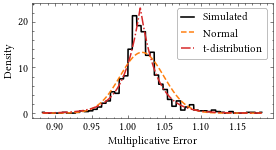

In [202]:
plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

figsize = (0.7 * ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(
    figsize=figsize,
)


sim_plotted = 0
l = LOC_NAMES[0]

for dist, dist_name, ls, lw, col in zip(
    [stats.norm, stats.gennorm],
    ["Normal", "t-distribution"],
    ["--", "-."],
    [1.5, 1.5],
    ["C1", "C3"],
):
    # Freedman-Diaconis rule
    r = ajf_utils.get_rv_hist(feat_error[l])

    xmin, xmax = r.interval(0.999)
    x = np.linspace(xmin, xmax, 1000)

    if sim_plotted < 1:
        ax.plot(
            x,
            r.pdf(x),
            label=rf"Simulated",
            lw=1.6,
            ls="-",
            c="k",
        )
        sim_plotted += 1

    params = dist.fit(feat_error[l])
    ax.plot(
        x,
        dist.pdf(x, *params),
        label=dist_name,
        ls=ls,
        lw=lw,
        c=col,
    )

    ax.set_xlabel("Multiplicative Error")
    ax.set_ylabel("Density")

    print("Simulated")
    print("---------")
    print(f"mean = {r.mean():.3}")
    print(f"std  = {r.std():.3}")
    print("---------")
    print("Fitted")
    print("---------")
    if dist_name == "t-dist.":
        print(f"d.f. = {params[0]:.3}")
    print(f"mean = {dist.mean(*params):.3}")
    print(f"std  = {dist.std(*params):.3}")
    print(
        f"KS p-val = {stats.kstest(feat_error[l], lambda x: dist.cdf(x, *params)).pvalue:.3}"
    )
    print()

ax.legend(handlelength=1.2)

fig.tight_layout()
ajf_plts.save_fig(fig, "figMultError.pdf")

# Fit and add noise for all features

In [203]:
params = {}
for l in LOC_NAMES:
    params[l] = dist.fit(feat_error[l])

In [204]:
# Reset seed used to generate random values
SEED = ajf_plts.get_seed("6b_estimate_and_add_noise.ipynb")

res_files = glob.glob(f"./temp_data/{RUN_ID}/{RUN_ID}_*_results.feather")

In [209]:
noisy_dfs = []
for f in res_files:
    df = pd.read_feather(f)
    for l in LOC_NAMES:
        noise = dist.rvs(*params[l], size=len(df), random_state=SEED)
        df[l] *= noise
    noisy_dfs.append(df)

# Join Results

In [210]:
concat_df = pd.concat(noisy_dfs).reset_index(drop=True)
concat_df.to_parquet(
    f"./{RUN_ID}_w_error",
)